In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
%matplotlib inline

In [2]:
df = pd.read_csv('data/food-box-metrics.csv')

In [3]:
df.head()

,customer,distribution_method,date,planned_method,final_method,completed_at,last_box_date,weekday,hour,morning_afternoon,is_unenrolled,deviation_from_plan,deviation_from_current,deviation_summary
0,Customer 3,pickup,2022-06-24,pickup,pickup,2022-06-25 11:45:05-04:00,NaN,Saturday,11,Morning,False,0,0,as planned
1,Customer 53,pickup,2022-06-24,pickup,pickup,2022-06-24 17:03:31-04:00,NaN,Friday,17,Afternoon,False,0,0,as planned
2,Customer 51,pickup,2022-06-24,pickup,pickup,2022-06-24 16:08:30-04:00,NaN,Friday,16,Afternoon,False,0,0,as planned
3,Customer 27,pickup,2022-06-24,pickup,pickup,2022-06-25 14:55:45-04:00,NaN,Saturday,14,Afternoon,False,0,0,as planned
4,Customer 2,delivery,2022-06-24,pickup,pickup,2022-06-25 11:29:58-04:00,NaN,Saturday,11,Morning,False,0,0,as planned


## Multiple subplots with trend lines

Prepare the data...

In [4]:
# get counts per date, weekday, and am/pm for plotting
pickups_only_mask = df['final_method'] == 'pickup'
ampm_df = df[pickups_only_mask].groupby(['date', 'weekday', 'morning_afternoon'], as_index=False).size()
ampm_df.rename(columns={'size': 'count'}, inplace=True)
ampm_df['timeslot'] = ampm_df['weekday'].astype(str) + ' ' + ampm_df['morning_afternoon'].astype(str)
ampm_df['date'] = pd.to_datetime(ampm_df['date'])
ampm_df.head()

,date,weekday,morning_afternoon,count,timeslot
0,2022-06-24,Friday,Afternoon,5,Friday Afternoon
1,2022-06-24,Friday,Morning,3,Friday Morning
2,2022-06-24,Saturday,Afternoon,8,Saturday Afternoon
3,2022-06-24,Saturday,Morning,6,Saturday Morning
4,2022-07-01,Friday,Afternoon,7,Friday Afternoon


Set up the figure, axes, and needed variables

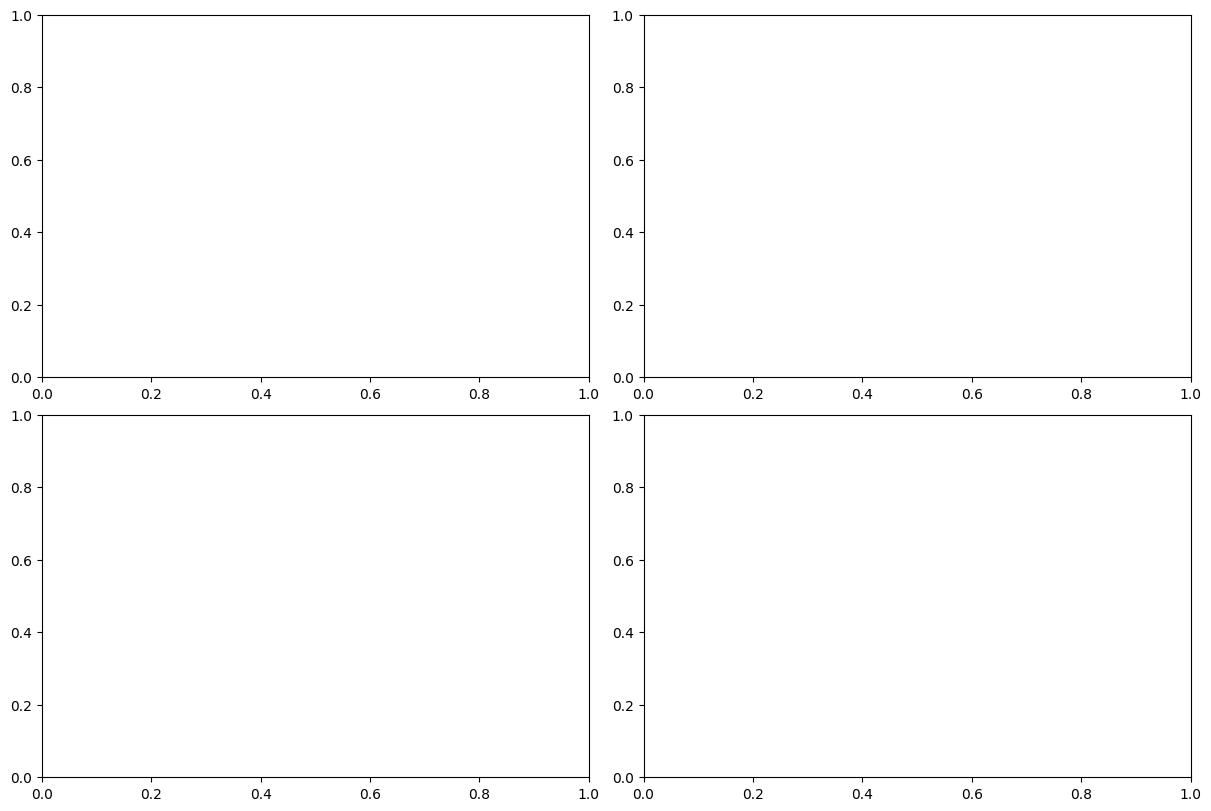

In [5]:
# constrained_layout automatically adjusts subplots and legends so they fit in the figure window
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), constrained_layout=True)

# flatten list of axes
axes = axes.reshape(-1)

# 4 separate time slots to plot
timeslots = list(ampm_df['timeslot'].unique())

# maximum for the y axis
ymax = ampm_df['count'].max() + 2

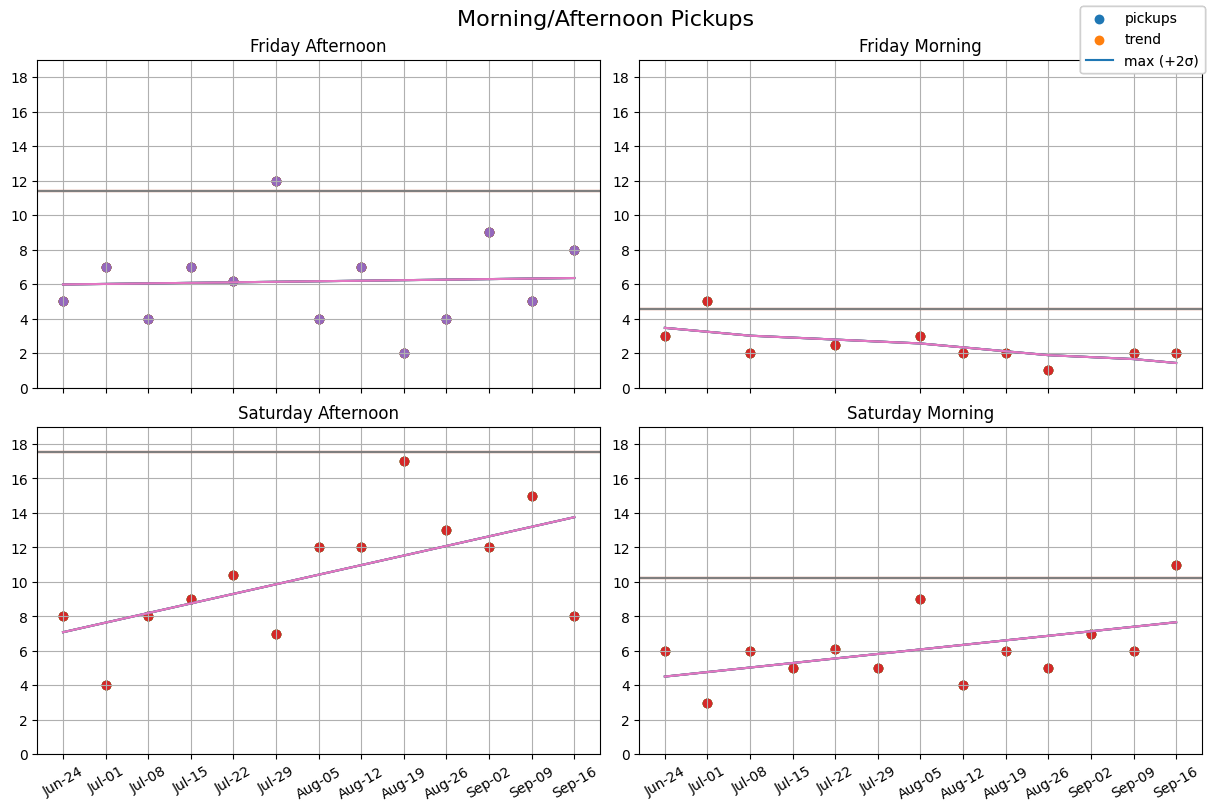

In [10]:
for i, ax in enumerate(axes):
    # create a df for the plot with the filtered rows, and only the necessary columns
    plot_df = ampm_df.loc[ampm_df['timeslot'] == timeslots[i],['date', 'count']]
    plot_df.set_index('date', inplace=True)

    # temporary fix for missing 2022-07-22 data - fill in with mean for each group
    avg_fill = plot_df['count'].mean()
    plot_df.loc[datetime(2022,7,22)] = {'count': avg_fill}
    plot_df.sort_index(inplace=True)
    
    # plot the box counts 
    ax.scatter(plot_df.index, plot_df['count'])
    ax.set_ylim(bottom=0, top=ymax)
    ax.set_title(timeslots[i])
    
    # plot the best fit line
    
    # create a set of evenly spaced x values to simplify the linear regression
    x_values = np.linspace(0, 1, len(plot_df.index))
    
    # create a best fit trend line
    trend = np.polyfit(x_values, plot_df['count'], deg=1)
    
    # create an equation function from the trend line that will convert x to y
    poly_eqn = np.poly1d(trend)
    
    # create a y value for every x value
    y_values = poly_eqn(x_values)
    
    # plot the trend line
    trend_line = ax.plot(plot_df.index, y_values, label='trend')
    
    ## plot a 'max' line at +2 std
    
    # create a set of x values that span all the way to the edge for the max line
    x_low, x_high = ax.get_xlim()
    x_vals_max = np.linspace(x_low, x_high, 10)
    max_est = plot_df['count'].mean() + 2 * plot_df['count'].std()
    max_line = ax.plot(x_vals_max, np.full_like(x_for_max, max_est), label='max (+2σ)')
    
    # set y ticks to all even numbers
    ax.set_yticks(np.arange(0,ymax, 2))
    
    # set x ticks to every date
    ax.set_xticks(plot_df.index)
    ax.set_xticklabels(ax.get_xticks(), rotation = 30)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    
    # turn on the grid
    ax.grid(True)

# add a figure-level legend
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
fig.legend(labels=['pickups', 'trend', 'max (+2σ)'], loc='upper right')
fig.suptitle('Morning/Afternoon Pickups', fontsize=16)
fig